In [1]:
%matplotlib inline

In [29]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [30]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


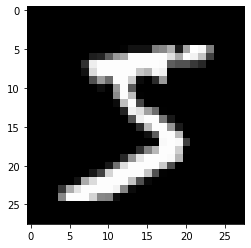

In [31]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [32]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [33]:
import torch.nn.functional as F
loss_func  = F.cross_entropy
def model(xb):
    return xb.mm(weights) + bias

bs = 64
xb = x_train[0:bs]
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))



tensor(14.4656, grad_fn=<NllLossBackward0>)


In [34]:
from torch import nn 

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hddien1 = nn.Linear(784, 128)
        self.hddien2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(self.hddien1(x))
        x = F.relu(self.hddien2(x))
        x = self.out(x)
        return x
    
net = Mnist_NN()
print(net)

Mnist_NN(
  (hddien1): Linear(in_features=784, out_features=128, bias=True)
  (hddien2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [35]:
# 打印定义好的权重和偏置项
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())

hddien1.weight Parameter containing:
tensor([[-0.0076, -0.0284,  0.0095,  ..., -0.0289,  0.0036,  0.0056],
        [ 0.0103,  0.0163, -0.0176,  ...,  0.0092,  0.0192, -0.0242],
        [-0.0051,  0.0182, -0.0290,  ..., -0.0109,  0.0290, -0.0279],
        ...,
        [ 0.0287, -0.0215,  0.0175,  ...,  0.0296, -0.0242, -0.0118],
        [ 0.0060,  0.0173,  0.0017,  ...,  0.0030,  0.0179, -0.0158],
        [ 0.0342, -0.0012, -0.0049,  ..., -0.0014,  0.0261, -0.0191]],
       requires_grad=True) torch.Size([128, 784])
hddien1.bias Parameter containing:
tensor([-0.0177, -0.0051,  0.0004, -0.0202, -0.0296, -0.0203,  0.0112, -0.0139,
        -0.0179, -0.0294,  0.0297,  0.0027,  0.0038,  0.0055,  0.0238, -0.0156,
        -0.0053, -0.0141,  0.0001, -0.0257, -0.0288, -0.0044,  0.0034,  0.0160,
         0.0072, -0.0165,  0.0060, -0.0096,  0.0119, -0.0161, -0.0117, -0.0265,
        -0.0300, -0.0291, -0.0093, -0.0202,  0.0175,  0.0270, -0.0035, -0.0002,
        -0.0245, -0.0289, -0.0068, -0.0111, 

In [36]:
# 使用TensorDataset和DataLoader来构建数据集
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [37]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2)
    )

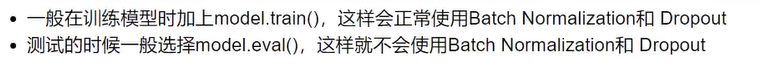

In [42]:
import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step: '+str(step), '验证集损失： '+str(val_loss))
        
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [43]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step: 0 验证集损失： 2.2779719646453858
当前step: 1 验证集损失： 2.243748181152344
当前step: 2 验证集损失： 2.1908896774291993
当前step: 3 验证集损失： 2.1038735759735108
当前step: 4 验证集损失： 1.9610933456420898
当前step: 5 验证集损失： 1.7475461795806886
当前step: 6 验证集损失： 1.4824673973083495
当前step: 7 验证集损失： 1.229479239654541
当前step: 8 验证集损失： 1.0329256521224977
当前step: 9 验证集损失： 0.8903914121627807
当前step: 10 验证集损失： 0.7854866606712342
当前step: 11 验证集损失： 0.7060445899963379
当前step: 12 验证集损失： 0.6449713467597962
当前step: 13 验证集损失： 0.5962431080818176
当前step: 14 验证集损失： 0.557201746225357
当前step: 15 验证集损失： 0.5248844560146332
当前step: 16 验证集损失： 0.49794581689834594
当前step: 17 验证集损失： 0.47546715207099916
当前step: 18 验证集损失： 0.4565473002433777
当前step: 19 验证集损失： 0.4402077147960663
当前step: 20 验证集损失： 0.42580241618156434
当前step: 21 验证集损失： 0.41260678825378416
当前step: 22 验证集损失： 0.40158806748390197
当前step: 23 验证集损失： 0.3916022066354752
当前step: 24 验证集损失： 0.38292234010696413
